## Data Preprocessing

In [102]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch


In [103]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

DEVICE = torch.device(
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)

print("Device:", DEVICE)


Device: mps


In [104]:
DATA_DIR = Path("archive_mr")

if not DATA_DIR.exists():
    raise FileNotFoundError(f"{DATA_DIR} not found!")
else:
    print(f"Data directory found: {DATA_DIR}\n")

    for root, dirs, files in os.walk(DATA_DIR):
        level = root.replace(str(DATA_DIR), '').count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(root)}/")
        if files:
            print(f"{indent}    {len(files)} files")


Data directory found: archive_mr

archive_mr/
    1 files
    Training/
        no_tumor/
            395 files
        meningioma_tumor/
            822 files
        glioma_tumor/
            826 files
        pituitary_tumor/
            827 files
    Testing/
        no_tumor/
            105 files
        meningioma_tumor/
            115 files
        glioma_tumor/
            100 files
        pituitary_tumor/
            74 files


In [105]:
def get_image_paths(data_dir):
    image_paths = []
    extensions = ['*.jpg', '*.jpeg', '*.png', '*.tif']

    for ext in extensions:
        image_paths.extend(list(data_dir.rglob(ext)))

    data = []
    for p in image_paths:
        label = p.parent.name
        split = (
            "Training" if "Training" in p.parts
            else "Testing" if "Testing" in p.parts
            else "Unspecified"
        )

        data.append({
            "path": str(p),
            "label": label,
            "split": split,
            "filename": p.name
        })

    return pd.DataFrame(data)


In [106]:
df = get_image_paths(DATA_DIR)
print("Total images:", len(df))
print(df.head())


Total images: 3264
                                         path     label    split  \
0   archive_mr/Testing/no_tumor/image(49).jpg  no_tumor  Testing   
1    archive_mr/Testing/no_tumor/image(1).jpg  no_tumor  Testing   
2  archive_mr/Testing/no_tumor/image(103).jpg  no_tumor  Testing   
3   archive_mr/Testing/no_tumor/image(73).jpg  no_tumor  Testing   
4   archive_mr/Testing/no_tumor/image(24).jpg  no_tumor  Testing   

         filename  
0   image(49).jpg  
1    image(1).jpg  
2  image(103).jpg  
3   image(73).jpg  
4   image(24).jpg  


In [107]:
label_clean_map = {
    'glioma_tumor': 'glioma',
    'meningioma_tumor': 'meningioma',
    'pituitary_tumor': 'pituitary',
    'no_tumor': 'no_tumor'
}

df['label'] = df['label'].map(label_clean_map)
print("Classes:", df['label'].unique())


Classes: <StringArray>
['no_tumor', 'meningioma', 'glioma', 'pituitary']
Length: 4, dtype: str


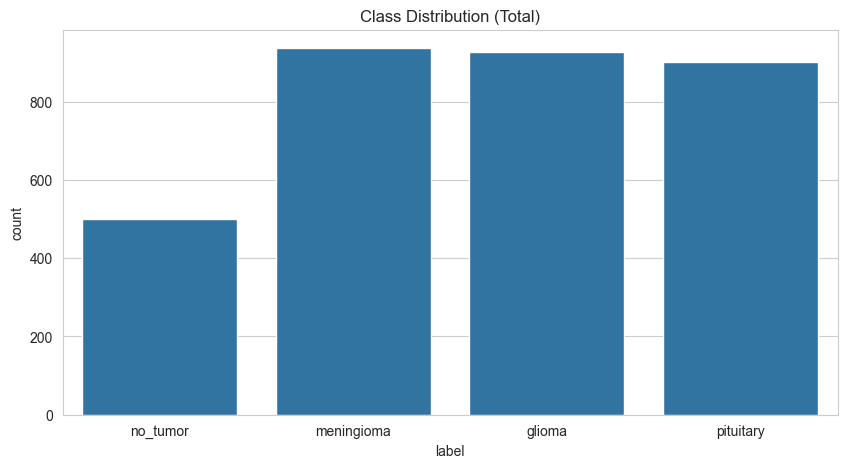

In [108]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='label')
plt.title("Class Distribution (Total)")
plt.show()


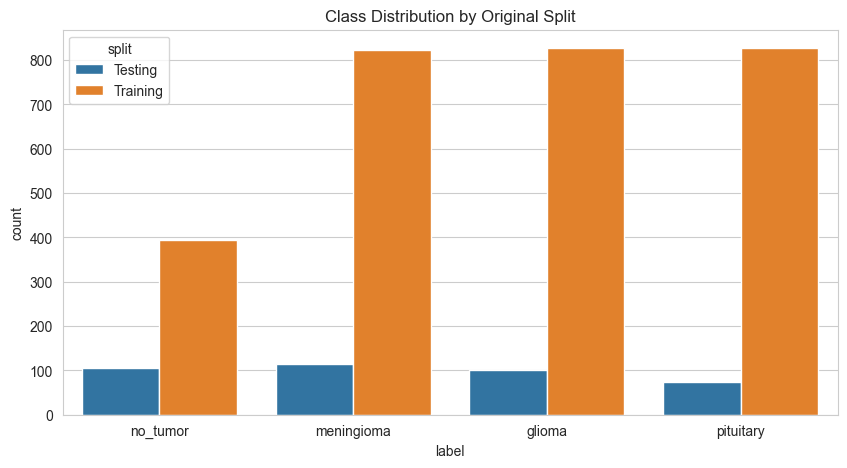

In [109]:
if df['split'].nunique() > 1:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x='label', hue='split')
    plt.title("Class Distribution by Original Split")
    plt.show()


In [110]:
def show_samples(df, n=4):
    classes = df['label'].unique()
    fig, axes = plt.subplots(len(classes), n, figsize=(15, 3 * len(classes)))

    for i, cls in enumerate(classes):
        samples = df[df['label'] == cls].sample(n, random_state=42)
        for j, (_, row) in enumerate(samples.iterrows()):
            img = Image.open(row['path'])
            ax = axes[i, j]
            ax.imshow(img, cmap='gray')
            ax.set_title(f"{cls}\n{img.size}")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

    


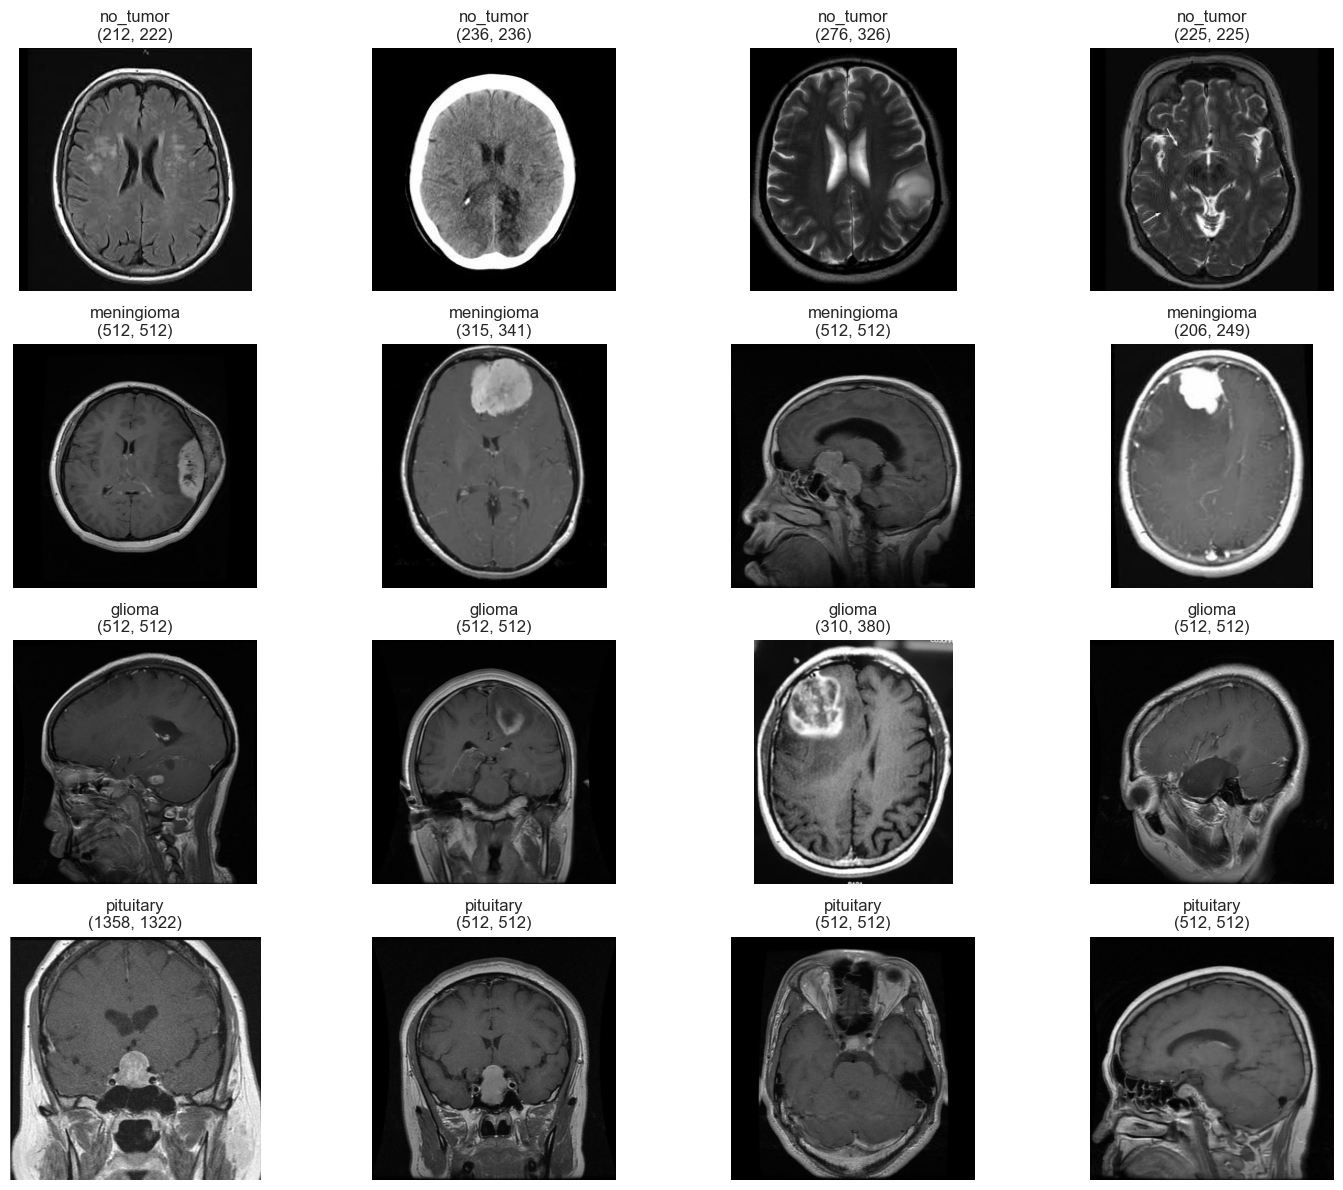

In [111]:
show_samples(df)


In [112]:
def check_image_stats(df, sample_size=500):
    subset = df.sample(sample_size, random_state=42) if len(df) > sample_size else df

    sizes, modes = [], []
    for p in subset['path']:
        with Image.open(p) as img:
            sizes.append(img.size)
            modes.append(img.mode)

    return sizes, modes


Image modes: {'RGB'}


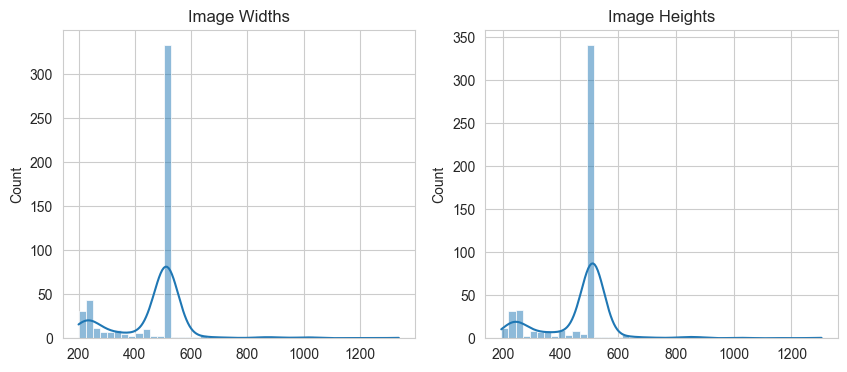

In [113]:
sizes, modes = check_image_stats(df)
print("Image modes:", set(modes))

widths = [s[0] for s in sizes]
heights = [s[1] for s in sizes]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(widths, kde=True)
plt.title("Image Widths")

plt.subplot(1, 2, 2)
sns.histplot(heights, kde=True)
plt.title("Image Heights")
plt.show()


In [114]:
train_val_df = df[df['split'] == 'Training'].copy()
test_df = df[df['split'] == 'Testing'].copy()

train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.2,
    stratify=train_val_df['label'],
    random_state=42
)

print("Train:", len(train_df))
print("Val:", len(val_df))
print("Test:", len(test_df))


Train: 2296
Val: 574
Test: 394


In [115]:
class MRI_Dataset(Dataset):
    def __init__(self, dataframe, transform=None, label_map=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
        self.label_map = label_map

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['path']).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.label_map[row['label']]
        return image, label


In [116]:
IMG_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])


In [117]:
classes = sorted(df['label'].unique())
label_map = {c: i for i, c in enumerate(classes)}
label_map_inv = {v: k for k, v in label_map.items()}

train_dataset = MRI_Dataset(train_df, train_transforms, label_map)
val_dataset = MRI_Dataset(val_df, val_test_transforms, label_map)
test_dataset = MRI_Dataset(test_df, val_test_transforms, label_map)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [118]:
def show_batch(loader):
    images, labels = next(iter(loader))
    plt.figure(figsize=(16, 8))

    for i in range(min(8, len(images))):
        ax = plt.subplot(2, 4, i + 1)
        img = images[i].permute(1, 2, 0).numpy()
        img = img * IMAGENET_STD + IMAGENET_MEAN
        img = np.clip(img, 0, 1)

        plt.imshow(img)
        plt.title(label_map_inv[labels[i].item()])
        plt.axis("off")

    plt.show()


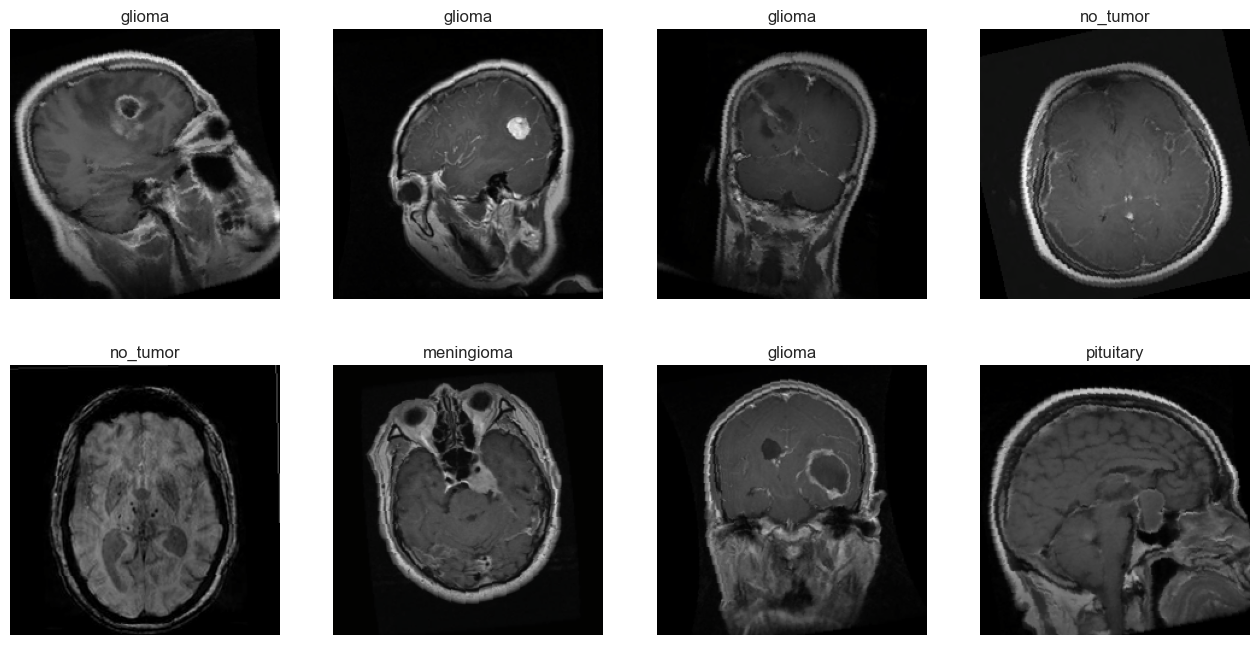

In [119]:
show_batch(train_loader)


## CNN 

In [120]:
import os
import time
import copy
import json
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
DEVICE = torch.device(
    "cuda" if torch.cuda.is_available()
    else ("mps" if torch.backends.mps.is_available() else "cpu")
)
print("Using device:", DEVICE)

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 12
LR = 1e-3
WEIGHT_DECAY = 1e-4


Using device: mps


In [122]:
label_clean_map = {
    "glioma_tumor": "glioma",
    "meningioma_tumor": "meningioma",
    "pituitary_tumor": "pituitary",
    "no_tumor": "no_tumor"
}

def load_dataset(root):
    data = []
    for split in ["Training", "Testing"]:
        split_dir = os.path.join(root, split)
        for cls in os.listdir(split_dir):
            if cls in label_clean_map:
                clean_label = label_clean_map[cls]
                cls_dir = os.path.join(split_dir, cls)
                for img in os.listdir(cls_dir):
                    if img.lower().endswith((".jpg", ".png", ".jpeg")):
                        data.append({
                            "path": os.path.join(cls_dir, img),
                            "label": clean_label,
                            "split": split
                        })
    return pd.DataFrame(data)

df = load_dataset(DATA_DIR)
print(df["label"].value_counts())


label
meningioma    937
glioma        926
pituitary     901
no_tumor      500
Name: count, dtype: int64


In [123]:
trainval_df = df[df["split"] == "Training"]
test_df = df[df["split"] == "Testing"]

train_df, val_df = train_test_split(
    trainval_df,
    test_size=0.2,
    stratify=trainval_df["label"],
    random_state=42
)

In [124]:
class MRIDataset(Dataset):
    def __init__(self, df, transform=None, label_map=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.label_map = label_map

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row["path"]).convert("RGB")
        label = self.label_map[row["label"]]

        if self.transform:
            image = self.transform(image)

        return image, label


In [125]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])


In [126]:
classes = sorted(df["label"].unique())
label_map = {c: i for i, c in enumerate(classes)}
inv_label_map = {v: k for k, v in label_map.items()}

train_ds = MRIDataset(train_df, train_tfms, label_map)
val_ds   = MRIDataset(val_df, val_tfms, label_map)
test_ds  = MRIDataset(test_df, val_tfms, label_map)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


In [127]:
def build_resnet18(num_classes=4):
    resnet_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # Freeze everything
    for p in resnet_model.parameters():
        p.requires_grad = False

    # Unfreeze layer4 + fc (best tradeoff)
    for p in resnet_model.layer4.parameters():
        p.requires_grad = True

    num_ftrs = resnet_model.fc.in_features
    resnet_model.fc = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(num_ftrs, num_classes)
    )

    return resnet_model.to(DEVICE)

resnet_model = build_resnet18(4)


In [149]:
criterion = nn.CrossEntropyLoss()

res_optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, resnet_model.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

scheduler = lr_scheduler.CosineAnnealingLR(res_optimizer, T_max=NUM_EPOCHS)


In [150]:
resnet_history = {
    "train_loss": [],
    "val_loss": [],
    "val_acc": [],
    "val_f1": []
}

In [151]:
best_model = copy.deepcopy(resnet_model.state_dict())
best_f1 = 0.0
history = []

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-"*30)

    for phase in ["train", "val"]:
        resnet_model.train() if phase == "train" else resnet_model.eval()
        loader = train_loader if phase == "train" else val_loader

        y_true, y_pred = [], []
        running_loss = 0.0

        for x, y in tqdm(loader, desc=phase):
            x, y = x.to(DEVICE), y.to(DEVICE)
            res_optimizer.zero_grad()

            with torch.set_grad_enabled(phase=="train"):
                outputs = resnet_model(x)
                loss = criterion(outputs, y)
                preds = torch.argmax(outputs, 1)

                if phase == "train":
                    loss.backward()
                    res_optimizer.step()

            running_loss += loss.item() * x.size(0)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

        epoch_loss = running_loss / len(loader.dataset)
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average="macro")
        
        if phase == "train":
            resnet_history["train_loss"].append(epoch_loss)
        else:
            resnet_history["val_loss"].append(epoch_loss)
            resnet_history["val_acc"].append(acc)
            resnet_history["val_f1"].append(f1) 

        print(f"{phase.upper()} | Loss: {epoch_loss:.4f} | Acc: {acc:.4f} | Macro-F1: {f1:.4f}")

        if phase == "val" and f1 > best_f1:
            best_f1 = f1
            best_model = copy.deepcopy(resnet_model.state_dict())

    scheduler.step()

resnet_model.load_state_dict(best_model)
torch.save(resnet_model.state_dict(), "best_resnet18.pth")



Epoch 1/12
------------------------------


train: 100%|██████████| 180/180 [00:16<00:00, 11.12it/s]


TRAIN | Loss: 0.2278 | Acc: 0.9209 | Macro-F1: 0.9228


val: 100%|██████████| 25/25 [00:01<00:00, 19.17it/s]


VAL | Loss: 2.2040 | Acc: 0.6827 | Macro-F1: 0.6314

Epoch 2/12
------------------------------


train: 100%|██████████| 180/180 [00:13<00:00, 13.17it/s]


TRAIN | Loss: 0.1708 | Acc: 0.9390 | Macro-F1: 0.9415


val: 100%|██████████| 25/25 [00:01<00:00, 19.84it/s]


VAL | Loss: 1.9359 | Acc: 0.6929 | Macro-F1: 0.6390

Epoch 3/12
------------------------------


train: 100%|██████████| 180/180 [00:14<00:00, 12.73it/s]


TRAIN | Loss: 0.1364 | Acc: 0.9544 | Macro-F1: 0.9557


val: 100%|██████████| 25/25 [00:01<00:00, 19.62it/s]


VAL | Loss: 1.5622 | Acc: 0.7157 | Macro-F1: 0.6830

Epoch 4/12
------------------------------


train: 100%|██████████| 180/180 [00:13<00:00, 12.86it/s]


TRAIN | Loss: 0.0967 | Acc: 0.9679 | Macro-F1: 0.9696


val: 100%|██████████| 25/25 [00:01<00:00, 18.02it/s]


VAL | Loss: 1.4803 | Acc: 0.7741 | Macro-F1: 0.7488

Epoch 5/12
------------------------------


train: 100%|██████████| 180/180 [00:13<00:00, 13.15it/s]


TRAIN | Loss: 0.0646 | Acc: 0.9787 | Macro-F1: 0.9800


val: 100%|██████████| 25/25 [00:01<00:00, 19.42it/s]


VAL | Loss: 2.3305 | Acc: 0.7030 | Macro-F1: 0.6662

Epoch 6/12
------------------------------


train: 100%|██████████| 180/180 [00:14<00:00, 12.83it/s]


TRAIN | Loss: 0.0669 | Acc: 0.9770 | Macro-F1: 0.9785


val: 100%|██████████| 25/25 [00:01<00:00, 19.76it/s]


VAL | Loss: 1.9541 | Acc: 0.7335 | Macro-F1: 0.6892

Epoch 7/12
------------------------------


train: 100%|██████████| 180/180 [00:13<00:00, 13.20it/s]


TRAIN | Loss: 0.0335 | Acc: 0.9871 | Macro-F1: 0.9883


val: 100%|██████████| 25/25 [00:01<00:00, 19.16it/s]


VAL | Loss: 2.0610 | Acc: 0.7563 | Macro-F1: 0.7163

Epoch 8/12
------------------------------


train: 100%|██████████| 180/180 [00:13<00:00, 13.09it/s]


TRAIN | Loss: 0.0231 | Acc: 0.9923 | Macro-F1: 0.9928


val: 100%|██████████| 25/25 [00:01<00:00, 19.92it/s]


VAL | Loss: 1.9604 | Acc: 0.7462 | Macro-F1: 0.7076

Epoch 9/12
------------------------------


train: 100%|██████████| 180/180 [00:15<00:00, 11.57it/s]


TRAIN | Loss: 0.0198 | Acc: 0.9948 | Macro-F1: 0.9951


val: 100%|██████████| 25/25 [00:01<00:00, 19.88it/s]


VAL | Loss: 2.2113 | Acc: 0.7538 | Macro-F1: 0.7136

Epoch 10/12
------------------------------


train: 100%|██████████| 180/180 [00:15<00:00, 11.40it/s]


TRAIN | Loss: 0.0111 | Acc: 0.9969 | Macro-F1: 0.9971


val: 100%|██████████| 25/25 [00:01<00:00, 18.53it/s]


VAL | Loss: 2.0497 | Acc: 0.7589 | Macro-F1: 0.7198

Epoch 11/12
------------------------------


train: 100%|██████████| 180/180 [00:15<00:00, 11.96it/s]


TRAIN | Loss: 0.0110 | Acc: 0.9955 | Macro-F1: 0.9954


val: 100%|██████████| 25/25 [00:01<00:00, 18.04it/s]


VAL | Loss: 2.0097 | Acc: 0.7690 | Macro-F1: 0.7366

Epoch 12/12
------------------------------


train: 100%|██████████| 180/180 [00:16<00:00, 11.02it/s]


TRAIN | Loss: 0.0125 | Acc: 0.9969 | Macro-F1: 0.9973


val: 100%|██████████| 25/25 [00:01<00:00, 19.13it/s]

VAL | Loss: 2.2553 | Acc: 0.7614 | Macro-F1: 0.7223


In [154]:
resnet_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        preds = torch.argmax(resnet_model(x), 1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("TEST Accuracy:", accuracy_score(y_true, y_pred))
print("TEST Macro F1:", f1_score(y_true, y_pred, average="macro"))

print(classification_report(
    y_true, y_pred,
    target_names=classes
))


TEST Accuracy: 0.7741116751269036
TEST Macro F1: 0.7488210236994342
              precision    recall  f1-score   support

      glioma       1.00      0.29      0.45       100
  meningioma       0.63      0.99      0.77       115
    no_tumor       0.83      1.00      0.91       105
   pituitary       1.00      0.77      0.87        74

    accuracy                           0.77       394
   macro avg       0.86      0.76      0.75       394
weighted avg       0.85      0.77      0.74       394



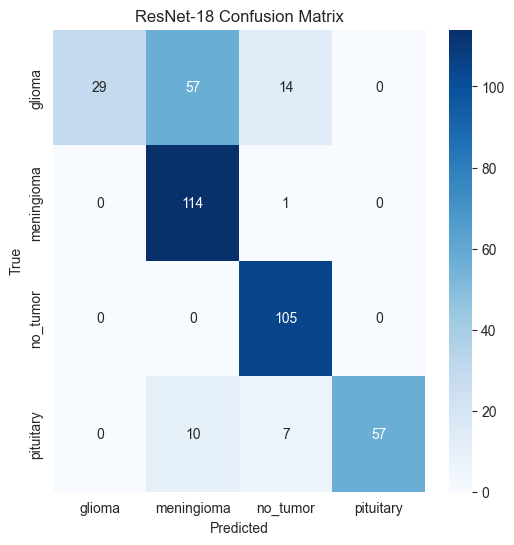

In [155]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=classes,
            yticklabels=classes,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("ResNet-18 Confusion Matrix")
plt.show()


## Task 3 -> ViT Baseline: DeiT-Tiny (ImageNet-pretrained)

In [133]:
!pip install torchmetrics

In [177]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
from torchmetrics.classification import MulticlassF1Score
from tqdm import tqdm


In [178]:
train_dir = "archive_mr/Training"
val_dir   = "archive_mr/Testing"

IMAGE_SIZE = 224
BATCH_SIZE = 16   
NUM_CLASSES = 4


In [179]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])


In [180]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [181]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model(
    "deit_tiny_patch16_224",
    pretrained=True,
    num_classes=NUM_CLASSES
).to(device)


In [182]:
# Tüm backbone'u dondur
for param in model.parameters():
    param.requires_grad = False

# Classification head + son transformer block açık
for param in model.head.parameters():
    param.requires_grad = True

for param in model.blocks[-2:].parameters():
    param.requires_grad = True


In [183]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4,
    weight_decay=1e-4
)

f1_metric = MulticlassF1Score(
    num_classes=NUM_CLASSES,
    average="macro"
).to(device)


In [184]:
EPOCHS = 12


In [185]:
vit_history = {
    "train_loss": [],
    "val_acc": [],
    "val_f1": []
}

In [186]:
best_f1 = 0.0

for epoch in range(EPOCHS):
    # ---- TRAIN ----
    model.train()
    train_loss = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # ---- VALIDATION ----
    model.eval()
    correct = 0
    total = 0
    f1_metric.reset()

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)
            f1_metric.update(preds, labels)

    val_acc = correct / total
    val_f1 = f1_metric.compute().item()

    print(f"\nEpoch {epoch+1}")
    print(f"Train Loss: {train_loss/len(train_loader):.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Validation Macro F1: {val_f1:.4f}")

    vit_history["train_loss"].append(train_loss / len(train_loader))
    vit_history["val_acc"].append(val_acc)
    vit_history["val_f1"].append(val_f1)


    # ---- SAVE BEST ----
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), "vit_best.pth")
        print(f"✔ New best ViT model saved (Macro-F1 = {best_f1:.4f})")


Epoch 1/12: 100%|██████████| 180/180 [00:24<00:00,  7.37it/s]



Epoch 1
Train Loss: 0.6294
Validation Accuracy: 0.5914
Validation Macro F1: 0.5681
✔ New best ViT model saved (Macro-F1 = 0.5681)


Epoch 2/12: 100%|██████████| 180/180 [00:23<00:00,  7.56it/s]



Epoch 2
Train Loss: 0.3417
Validation Accuracy: 0.6574
Validation Macro F1: 0.6384
✔ New best ViT model saved (Macro-F1 = 0.6384)


Epoch 3/12: 100%|██████████| 180/180 [00:23<00:00,  7.77it/s]



Epoch 3
Train Loss: 0.2647
Validation Accuracy: 0.7081
Validation Macro F1: 0.6750
✔ New best ViT model saved (Macro-F1 = 0.6750)


Epoch 4/12: 100%|██████████| 180/180 [00:23<00:00,  7.80it/s]



Epoch 4
Train Loss: 0.2145
Validation Accuracy: 0.7310
Validation Macro F1: 0.7020
✔ New best ViT model saved (Macro-F1 = 0.7020)


Epoch 5/12: 100%|██████████| 180/180 [00:23<00:00,  7.79it/s]



Epoch 5
Train Loss: 0.1804
Validation Accuracy: 0.7640
Validation Macro F1: 0.7310
✔ New best ViT model saved (Macro-F1 = 0.7310)


Epoch 6/12: 100%|██████████| 180/180 [00:22<00:00,  7.84it/s]



Epoch 6
Train Loss: 0.1613
Validation Accuracy: 0.7563
Validation Macro F1: 0.7442
✔ New best ViT model saved (Macro-F1 = 0.7442)


Epoch 7/12: 100%|██████████| 180/180 [00:23<00:00,  7.67it/s]



Epoch 7
Train Loss: 0.1282
Validation Accuracy: 0.7792
Validation Macro F1: 0.7545
✔ New best ViT model saved (Macro-F1 = 0.7545)


Epoch 8/12: 100%|██████████| 180/180 [00:22<00:00,  7.83it/s]



Epoch 8
Train Loss: 0.1086
Validation Accuracy: 0.7563
Validation Macro F1: 0.7222


Epoch 9/12: 100%|██████████| 180/180 [00:23<00:00,  7.72it/s]



Epoch 9
Train Loss: 0.1061
Validation Accuracy: 0.7107
Validation Macro F1: 0.6746


Epoch 10/12: 100%|██████████| 180/180 [00:22<00:00,  7.87it/s]



Epoch 10
Train Loss: 0.0821
Validation Accuracy: 0.7665
Validation Macro F1: 0.7259


Epoch 11/12: 100%|██████████| 180/180 [00:23<00:00,  7.59it/s]



Epoch 11
Train Loss: 0.0792
Validation Accuracy: 0.7766
Validation Macro F1: 0.7379


Epoch 12/12: 100%|██████████| 180/180 [00:25<00:00,  7.07it/s]



Epoch 12
Train Loss: 0.0693
Validation Accuracy: 0.7411
Validation Macro F1: 0.6977


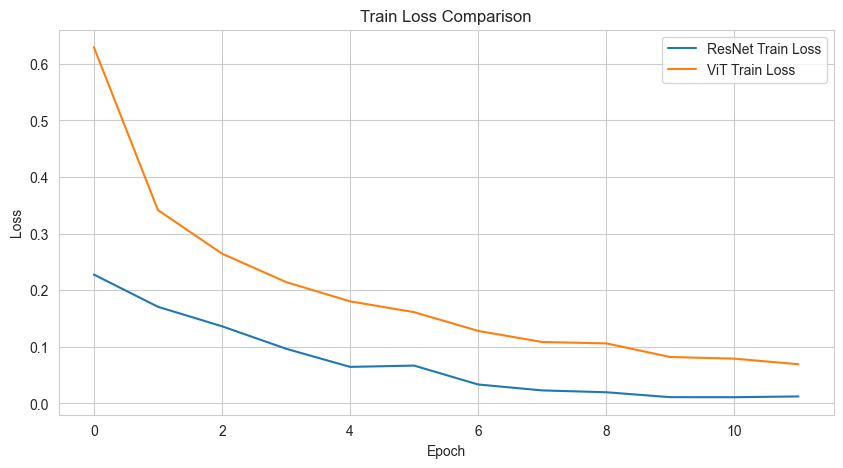

In [187]:
plt.figure(figsize=(10,5))
plt.plot(resnet_history["train_loss"], label="ResNet Train Loss")
plt.plot(vit_history["train_loss"], label="ViT Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Loss Comparison")
plt.legend()
plt.show()


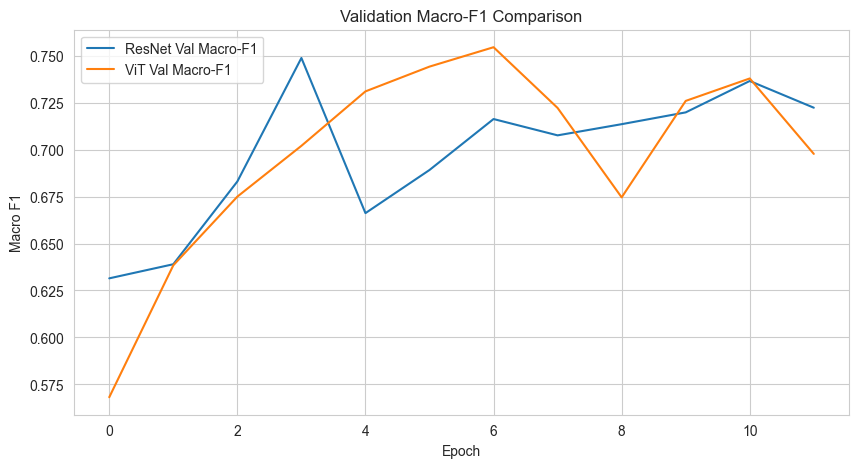

In [188]:
plt.figure(figsize=(10,5))
plt.plot(resnet_history["val_f1"], label="ResNet Val Macro-F1")
plt.plot(vit_history["val_f1"], label="ViT Val Macro-F1")
plt.xlabel("Epoch")
plt.ylabel("Macro F1")
plt.title("Validation Macro-F1 Comparison")
plt.legend()
plt.show()


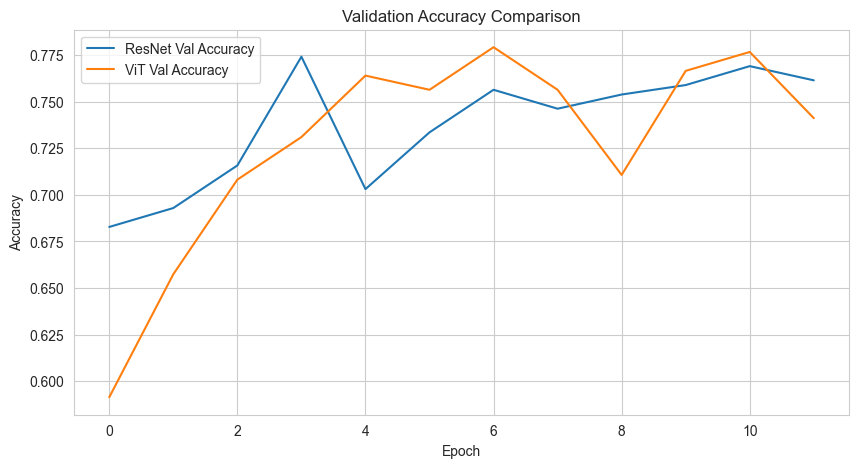

In [189]:
plt.figure(figsize=(10,5))
plt.plot(resnet_history["val_acc"], label="ResNet Val Accuracy")
plt.plot(vit_history["val_acc"], label="ViT Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Comparison")
plt.legend()
plt.show()


In [190]:
def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

resnet_total, resnet_trainable = count_params(resnet_model)
vit_total, vit_trainable = count_params(model)


In [191]:
resnet_model = resnet_model.to(device)
vit_model = model.to(device)


In [192]:
import time

def measure_epoch_time(model, dataloader, criterion, device):
    model.train()
    start = time.time()

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

    end = time.time()
    return end - start


In [193]:
resnet_epoch_time = measure_epoch_time(
    resnet_model, train_loader, criterion, device
)

vit_epoch_time = measure_epoch_time(
    vit_model, train_loader, criterion, device
)

print(f"ResNet-18 epoch time: {resnet_epoch_time:.2f} sec")
print(f"DeiT-Tiny epoch time: {vit_epoch_time:.2f} sec")


ResNet-18 epoch time: 53.16 sec
DeiT-Tiny epoch time: 17.81 sec


## Test Set Evaluation

In [194]:
from sklearn.metrics import accuracy_score, f1_score
import torch

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")

    return acc, macro_f1


In [195]:
resnet_test_acc, resnet_test_f1 = evaluate_model(
    resnet_model, test_loader, device
)

vit_test_acc, vit_test_f1 = evaluate_model(
    vit_model, test_loader, device
)

print(f"ResNet-18 TEST | Acc: {resnet_test_acc:.4f} | Macro-F1: {resnet_test_f1:.4f}")
print(f"DeiT-Tiny TEST | Acc: {vit_test_acc:.4f} | Macro-F1: {vit_test_f1:.4f}")


ResNet-18 TEST | Acc: 0.7792 | Macro-F1: 0.7528
DeiT-Tiny TEST | Acc: 0.7411 | Macro-F1: 0.6977


In [196]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, dataloader, class_names, device, title):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)

    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(title)
    plt.show()


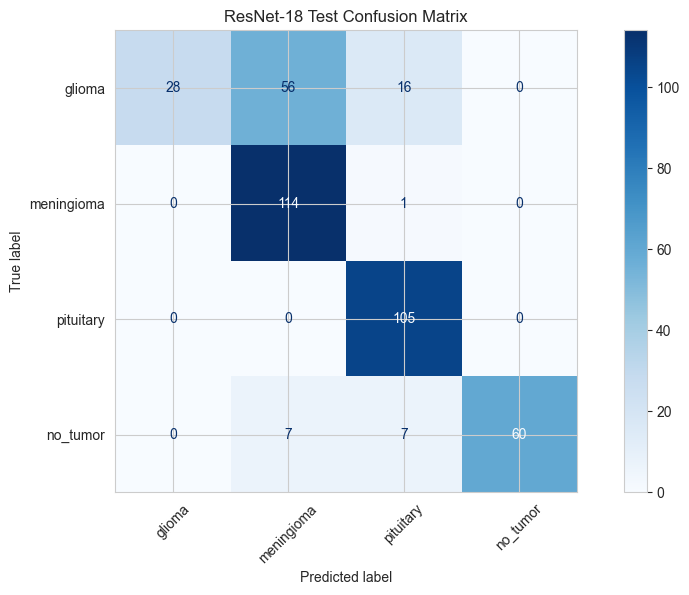

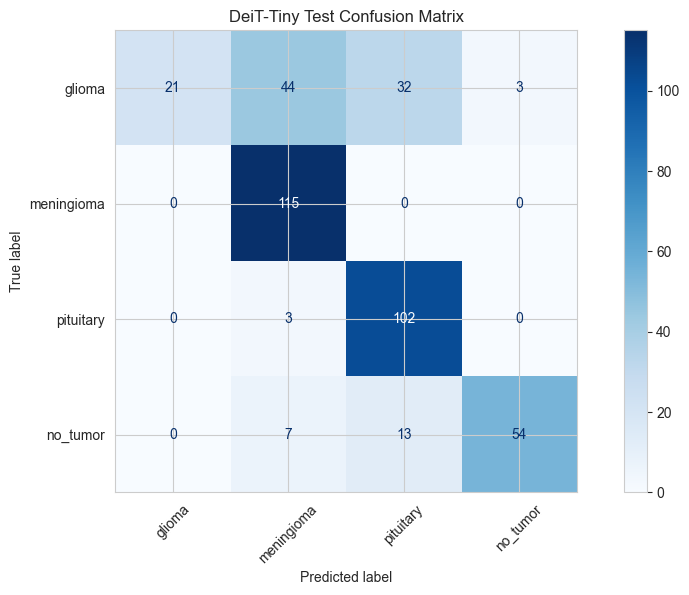

In [197]:
class_names = ["glioma", "meningioma", "pituitary", "no_tumor"]

plot_confusion_matrix(
    resnet_model, test_loader, class_names, device,
    title="ResNet-18 Test Confusion Matrix"
)

plot_confusion_matrix(
    vit_model, test_loader, class_names, device,
    title="DeiT-Tiny Test Confusion Matrix"
)


### Inference Time

In [198]:
def measure_inference_time(model, dataloader, device, num_batches=10):
    model.eval()
    times = []

    with torch.no_grad():
        for i, (images, _) in enumerate(dataloader):
            if i >= num_batches:
                break

            images = images.to(device)

            start = time.time()
            _ = model(images)
            end = time.time()

            times.append(end - start)

    return sum(times) / len(times)


resnet_inf_time = measure_inference_time(
    resnet_model, test_loader, device
)

vit_inf_time = measure_inference_time(
    vit_model, test_loader, device
)

print(f"ResNet-18 inference time (avg batch): {resnet_inf_time:.4f} sec")
print(f"DeiT-Tiny inference time (avg batch): {vit_inf_time:.4f} sec")


ResNet-18 inference time (avg batch): 0.5123 sec
DeiT-Tiny inference time (avg batch): 0.1913 sec


In [199]:
resnet_best_f1 = 0.7488  # loglardan aldığın değer
vit_best_f1 = max(vit_history["val_f1"])


In [200]:
print("ResNet loss:", resnet_history["train_loss"])
print("ViT loss:", vit_history["train_loss"])


ResNet loss: [0.22776852738151152, 0.17080387511527498, 0.1363921147917206, 0.09672316023203761, 0.0646265152413463, 0.06691336192402385, 0.03352886946670685, 0.023075578675462574, 0.01980737881882616, 0.011119090733102131, 0.011032545944928916, 0.01245281582208227]
ViT loss: [0.6293991578949822, 0.34174080677330493, 0.26474104711992874, 0.21454817397106024, 0.18041140833455654, 0.16129533865799506, 0.12819195741839293, 0.10858507285463727, 0.10613336057867855, 0.08205252479787709, 0.07917536082418843, 0.06929370394726801]


In [201]:
resnet_best_f1 = max(resnet_history["val_f1"])
vit_best_f1 = max(vit_history["val_f1"])

print("Best ResNet Val F1:", resnet_best_f1)
print("Best ViT Val F1:", vit_best_f1)


Best ResNet Val F1: 0.7488210236994342
Best ViT Val F1: 0.7545406818389893


In [202]:
import pandas as pd

results_df = pd.DataFrame({
    "Model": ["ResNet-18", "DeiT-Tiny"],
    "Total Params (M)": [resnet_total / 1e6, vit_total / 1e6],
    "Trainable Params (M)": [resnet_trainable / 1e6, vit_trainable / 1e6],
    "Best Val Macro-F1": [resnet_best_f1, vit_best_f1],
    "Epoch Time (sec)": [resnet_epoch_time, vit_epoch_time],
    "Inference Time (sec)": [resnet_inf_time, vit_inf_time]
})

results_df


,Model,Total Params (M),Trainable Params (M),Best Val Macro-F1,Epoch Time (sec),Inference Time (sec)
0,ResNet-18,11.178564,8.39578,0.748821,53.161110,0.512250
1,DeiT-Tiny,5.525188,0.89050,0.754541,17.812465,0.191339


In [210]:
! pip install thop


In [211]:
from thop import profile

dummy_input = torch.randn(1, 3, 224, 224).to(device)

resnet_flops, _ = profile(resnet_model, inputs=(dummy_input,), verbose=False)
vit_flops, _ = profile(vit_model, inputs=(dummy_input,), verbose=False)

print("ResNet FLOPs (G):", resnet_flops / 1e9)
print("ViT FLOPs (G):", vit_flops / 1e9)


ResNet FLOPs (G): 1.82352384
ViT FLOPs (G): 1.074660096
